# Calculate requests threshold for a web service

**Given the initial data about the last 4 weeks, we want to estimate when the threshold 100,000 requests per hour will be hit.**

In [1]:
import scipy as sp

#import data from tsv
data = sp.genfromtxt("web_traffic.tsv", delimiter="\t")

print(data[:10])

[[  1.00000000e+00   2.27200000e+03]
 [  2.00000000e+00              nan]
 [  3.00000000e+00   1.38600000e+03]
 [  4.00000000e+00   1.36500000e+03]
 [  5.00000000e+00   1.48800000e+03]
 [  6.00000000e+00   1.33700000e+03]
 [  7.00000000e+00   1.88300000e+03]
 [  8.00000000e+00   2.28300000e+03]
 [  9.00000000e+00   1.33500000e+03]
 [  1.00000000e+01   1.02500000e+03]]


In [3]:
print(data.shape)

(743, 2)


##### It is more convenient for `SciPy` to separate the dimensions into two vectors.

In [4]:
x = data[:, 0]
y = data[:, 1]

Find if there is some `NaN`

In [5]:
sp.sum(sp.isnan(y))

8

##### We can exclude this record from the set

In [8]:
x = x[~sp.isnan(x)]
y = y[~sp.isnan(y)]

##### Print the data in dots:

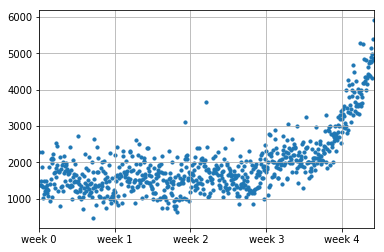

In [84]:
import matplotlib.pyplot as plt

def print_dots():
    plt.scatter(x, y, s=10)
    plt.xticks([w*7*24 for w in range(10)], ['week {}'.format(w) for w in range(10)])
    plt.autoscale(True, 'x', tight=True)

print_dots()
plt.grid()
plt.show()

### Building a simple model

#### Define error evaluation

In [11]:
def error(f, x, y):
    """
    Square of the difference.
    """
    return sp.sum((f(x) - y) ** 2)

#### Start from a straight line

`sp.polyfit()` ([doc](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html)) returns the (polynomial coefficient of the) model function that minimize the error for a given polynomial

In [19]:
fp1, residuals, rank, sv, round_ = sp.polyfit(x, y, 1, full=True)
print('Polynomial coefficients: {}'.format(fp1))
print('Residuals: {}'.format(residuals))
print('---')
print('Best straight line to fit the data is: f(x) = {} * x + {}'.format(fp1[0], fp1[1]))

Polynomial coefficients: [   2.59619213  989.02487106]
Residuals: [  3.17389767e+08]
---
Best straight line to fit the data is: f(x) = 2.596192127745884 * x + 989.0248710607148


#### Plotting more precise models

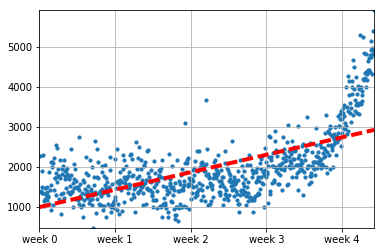

In [86]:
# print a line model for the data
def print_dots():
    plt.scatter(x, y, s=10)
    plt.xticks([w*7*24 for w in range(10)], ['week {}'.format(w) for w in range(10)])
    plt.autoscale(tight=True)

print_dots()

f1 = sp.poly1d(fp1)
fx = sp.linspace(0, x[-1], 1000)
plt.plot(fx, f1(fx), 'r--', linewidth=4)
plt.autoscale(tight=True)
plt.grid()
plt.show()

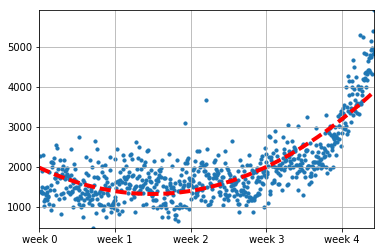

In [88]:
# print a line model for the data with greater degree (2)
def print_dots():
    plt.scatter(x, y, s=10)
    plt.xticks([w*7*24 for w in range(10)], ['week {}'.format(w) for w in range(10)])
    plt.autoscale(tight=True)

print_dots()

fp2 = sp.polyfit(x, y, 2)
f2 = sp.poly1d(fp2)
fx = sp.linspace(0, x[-1], 1000)
plt.plot(fx, f2(fx), 'r--', linewidth=4)
plt.autoscale(tight=True)
plt.grid()
plt.show()

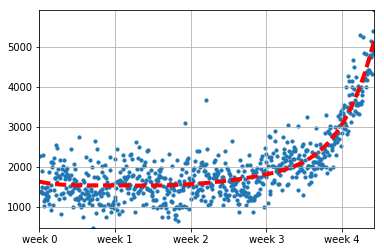

In [89]:
# print a line model for the data with greater degree (2)
def print_dots():
    plt.scatter(x, y, s=10)
    plt.xticks([w*7*24 for w in range(10)], ['week {}'.format(w) for w in range(10)])

print_dots()

fp3 = sp.polyfit(x, y, 6)
f3 = sp.poly1d(fp3)
fx = sp.linspace(0, x[-1], 1000)
plt.plot(fx, f3(fx), 'r--', linewidth=4)
plt.autoscale(tight=True)
plt.grid()
plt.show()

#### Considering only the meaningful trend

We consider only the inflection after week 3

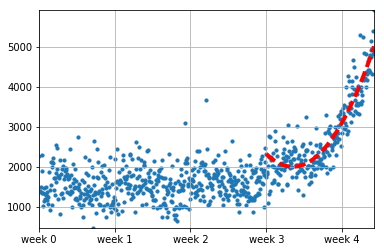

In [96]:
inflection = 3 * 7 * 24
xb = x[inflection:]
yb = y[inflection:]

fb = sp.poly1d(sp.polyfit(xb, yb, 2))

# print a line model for the data with greater degree (2) 
# only the data after the inflection (week 3) 
def print_dots():
    plt.scatter(x, y, s=10)
    plt.xticks([w*7*24 for w in range(10)], ['week {}'.format(w) for w in range(10)])

print_dots()
fx = sp.linspace(inflection, x[-1], 1000)
plt.plot(fx, fb(fx), 'r--', linewidth=4)
plt.autoscale(tight=True)
plt.grid()
plt.show()

#### Predict future data

After testing the error of each degree, we spot the function that model the best the given behavior. Using this model we can esteemate at which week the service will reach 100,000 requests per hour:

In [50]:
print(fb)

           3          2
0.0002064 x - 0.2964 x + 138.5 x - 1.881e+04


In [97]:
from scipy.optimize import fsolve
reach_max = fsolve(fb - 100000, 800) / (7 * 24)
print('100,000 requests expected at week {}'.format(reach_max[0]))

100,000 requests expected at week 9.476745539284273
